In [1]:

import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./dogs_images"


In [3]:
raw_pdf_elements = partition_pdf(
    filename="C:\\Users\\Barani\\Desktop\\chatbot\\dogs.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [6]:
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOllama(model="mistral",temperature=0 ),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

In [9]:
import os
import ollama
from tqdm import tqdm

# Initialize an empty list to store the results
img_summaries = []

# Define the directory path
dir_path = "C:\\Users\\Barani\\Desktop\\chatbot\\dogs_images"

# Get a list of all .jpg files in the directory
jpg_files = [f for f in os.listdir(dir_path) if f.endswith(".jpg")]

# Iterate over all .jpg files in the directory with a tqdm progress bar
for filename in tqdm(jpg_files, desc="Processing images"):
    # Construct the full file path
    file_path = os.path.join(dir_path, filename)
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'Describe this image :',
                'images':[file_path]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

# Print the image_summary list
print(img_summaries)


Processing images: 100%|██████████| 11/11 [03:33<00:00, 19.39s/it]

[' The image is a logo featuring the acronym "USDA" in capital letters, with the word "USDA" directly beneath it. To the left of the text, there\'s a graphic element that appears to be a stylized representation of wheat or grain, symbolizing agriculture, which aligns with USDA being an abbreviation for the United States Department of Agriculture. The overall design is minimalistic, using a combination of blue and white colors. In the upper right corner, there\'s a small graphic that seems to represent a farmer, suggesting a connection to farming or rural life. The logo has a clean, professional look typical of governmental organizations. ', ' The image is a close-up photograph of an animal\'s mouth. Inside the mouth, there is a visible dental issue with significant plaque and tartar buildup on the teeth. A yellow arrow points to one particular tooth that appears to be heavily affected by these deposits. The teeth have been identified as needing attention. The image has a watermark at t

In [10]:
len(img_summaries)

11

In [11]:
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

In [12]:
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)

In [13]:
len(image_elements)

11

In [15]:
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))

In [16]:
vectorstore.save_local("dog_faiss_index")

In [5]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')


In [6]:
db = FAISS.load_local("dog_faiss_index", embeddings,allow_dangerous_deserialization=True)

In [7]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [8]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [32]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, (base64.b64decode(relevant_images[0]))

In [26]:
result, relevant_images = answer("What is Gingivitis?")
print(result)

 Gingivitis is a dental condition characterized by inflammation of the gums around the teeth. It is typically the earliest stage of periodontal disease (PD) in dogs, and it can lead to more severe forms of PD if left untreated. The signs of gingivitis include mild redness and swelling of the gums, as well as a small amount of tartar buildup on the teeth. During a routine dental exam, a veterinarian may diagnose gingivitis based on visual assessment and palpation of the gums. Treatment for gingivitis usually involves professional cleaning of the teeth, followed by at-home oral care practices such as brushing the dog's teeth daily and providing dental chews or toys to help reduce plaque buildup. Preventive measures, such as regular dental check-ups and proper home care, can help prevent or minimize the development of gingivitis in dogs.


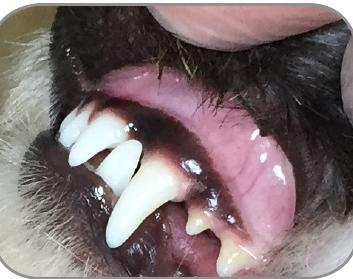

In [20]:
display.display(display.Image(base64.b64decode(relevant_images[2])))


In [21]:
result, relevant_images = answer("What is Early periodontits?")


In [23]:
result

" Early Periodontitis, also known as Grade I! periodontitis, is an initial stage of periodontal disease in dogs. In this stage, there are mild signs of inflammation and tartar buildup on the teeth. The gums may exhibit some redness, but they remain attached to the teeth with no significant recession or loosening. At this stage, the disease is still reversible with proper dental care and treatment. Regular brushing, professional cleaning, and addressing any underlying causes such as dietary issues can help prevent the progression of periodontitis. It's essential to monitor your dog's oral health closely and consult a veterinarian if you notice any signs of periodontal disease."

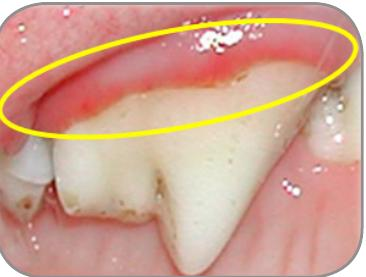

In [22]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [ ]:
# import gradio as gr

# def wrapper_func(question):
    
#     def answer(question):
#             from langchain.vectorstores import FAISS
#             from langchain.chains import LLMChain
#             from langchain_community.chat_models import ChatOllama
#             from langchain.prompts import PromptTemplate



#             qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
#                         prompt=PromptTemplate.from_template(prompt_template))
#             embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')
#             db = FAISS.load_local("dog_faiss_index", embeddings,allow_dangerous_deserialization=True)
#             relevant_docs = db.similarity_search(question)
#             context = ""
#             relevant_images = []
#             for d in relevant_docs:
#                 if d.metadata['type'] == 'text':
#                     context += '[text]' + d.metadata['original_content']
#                 elif d.metadata['type'] == 'table':
#                     context += '[table]' + d.metadata['original_content']
#                 elif d.metadata['type'] == 'image':
#                     context += '[image]' + d.page_content
#                     relevant_images.append(d.metadata['original_content'])
#             result = qa_chain.run({'context': context, 'question': question})
#             return result, relevant_images
#     result, relevant_images = answer(question)
#     return result, relevant_images

# iface = gr.Interface(fn=wrapper_func, 
#                      inputs="text", 
#                      outputs=["text", "image"],
#                      interpretation="default")

# iface.launch()


In [33]:
import gradio as gr



iface = gr.Interface(fn=answer, 
                     inputs="text", 
                     outputs=["text", "image"])

iface.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\gradio\queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\gradio\route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\gradio\blocks.py", line 1795, in process_api
    data = await self.postprocess_data(fn_index, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\gradio\blocks.py", line 1623, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\